In [5]:
import os
import torch
from unet import Unet
from clustertools import build_datacube
from matplotlib import pyplot as plt 
import numpy as np

In [7]:
datacube = build_datacube("monuseg-unet-hard")
datacube.domain

{'distil_target_mode': ['hard_dice', 'soft'],
 'monu_ms': ['13315092',
  '21081788',
  '26735830',
  '35788921',
  '56755036',
  '56882282',
  '65682867',
  '91090292',
  '93410762',
  '96319575'],
 'monu_nc': ['1', '2', '3', '4', '5'],
 'monu_rr': ['0.25', '0.5', '0.9'],
 'n_calibration': ['0', '1'],
 'no_distillation': ['False', 'True'],
 'weights_minimum': ['0.0', '0.1', '0.5'],
 'weights_mode': ['balance_gt',
  'constant',
  'pred_consistency',
  'pred_entropy',
  'pred_merged'],
 'weights_neighbourhood': ['1', '2']}

In [27]:
selected_cube = datacube(monu_ms='13315092', monu_nc='2', monu_rr='0.9', n_calibration='1', no_distillation='False', weights_minimum='0.0', weights_mode='balance_gt', weights_neighbourhood='2', distil_target_mode='hard_dice')

In [31]:
selected_cube.metadata

{'aug_blur_sigma_extent': '0.1',
 'aug_hed_bias_range': '0.025',
 'aug_hed_coef_range': '0.025',
 'aug_noise_var_extent': '0.05',
 'batch_size': '8',
 'dataset': 'monuseg',
 'epochs': '50',
 'init_fmaps': '8',
 'iter_per_epoch': '150',
 'loss': 'bce',
 'lr': '0.001',
 'lr_sched_cooldown': '10',
 'lr_sched_factor': '0.5',
 'lr_sched_patience': '5',
 'no_groundtruth': 'False',
 'overlap': '0',
 'rseed': '42',
 'save_cues': 'False',
 'sparse_data_max': '1.0',
 'sparse_data_rate': '1.0',
 'sparse_start_after': '15',
 'tile_size': '512',
 'weights_consistency_fn': 'quadratic',
 'weights_constant': '1.0',
 'zoom_level': '0',
 'distil_target_mode': 'hard_dice',
 'monu_ms': '13315092',
 'monu_nc': '2',
 'monu_rr': '0.9',
 'n_calibration': '1',
 'no_distillation': 'False',
 'weights_minimum': '0.0',
 'weights_mode': 'balance_gt',
 'weights_neighbourhood': '2'}

In [30]:
save_paths = selected_cube("save_path")

In [46]:
from monuseg import MonusegDatasetGenerator
from dataset import predict_roi
from augment import get_aug_transforms, get_norm_transform
from cytomine import Cytomine

In [52]:
cytomine = Cytomine.connect("https://research.cytomine.be", "13cad665-8b7a-4f9f-a6c0-93166e33ddb2", "520c4556-7f36-4cf1-82af-010f6be9adb3")

In [53]:
dataset = MonusegDatasetGenerator("/scratch/users/rmormont/monuseg", 512, 
                                      missing_seed=int(selected_cube.metadata['monu_ms']), 
                                      remove_ratio=float(selected_cube.metadata['monu_rr']), 
                                      n_complete=int(selected_cube.metadata['monu_nc']), 
                                      n_calibrate=1)

In [73]:
incomplete_list, complete_list, val_set_list, calibration_list = dataset.sets()
image, mask, _, _, _ = incomplete_list[0].crop_and_mask()

In [74]:
from matplotlib import pyplot as plt

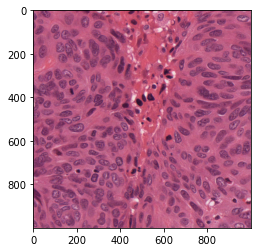

In [75]:
plt.imshow(image)

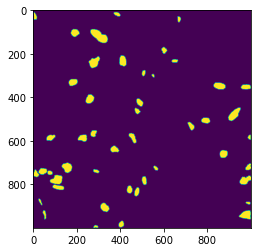

In [71]:
plt.imshow(mask)

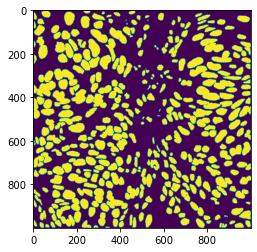

In [83]:
from skimage.io import imread
real_mask_path = incomplete_list[0].img_path.replace("13315092_0.9000_2", "42_0.0000_30").replace("tif", "png").replace("images", "masks").replace("incomplete", "complete")
plt.imshow(imread(real_mask_path))

In [84]:
from sldc.locator import mask_to_objects_2d

In [104]:
def generate_mask(crop, m_path):
    device = torch.device("cpu")
    unet = Unet(int(datacube.metadata["init_fmaps"]), n_classes=1)
    unet.load_state_dict(torch.load(m_path, map_location=device))
    unet.to(device)
    unet.eval()
    
    y_pred, y_true = predict_roi(
        crop, [], unet, device,
        in_trans=get_norm_transform(), batch_size=8,
        tile_size=512, overlap=0, n_jobs=1, zoom_level=0
    )
    
    plt.imshow(y_pred)
    

In [105]:
model_path = '/home/rmormont/models/monuseg-unet/hard/weights'
mem_crop =  incomplete_list[0]

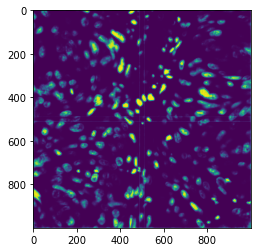

In [106]:
generate_mask(mem_crop, os.path.join(model_path, save_paths[0]))

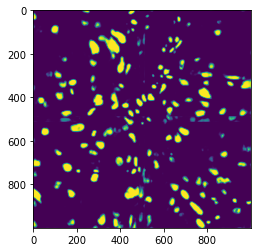

In [107]:
generate_mask(mem_crop, os.path.join(model_path, save_paths[5]))

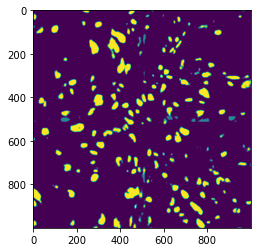

In [108]:
generate_mask(mem_crop, os.path.join(model_path, save_paths[14]))

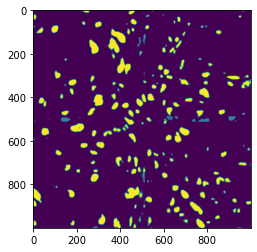

In [109]:
generate_mask(mem_crop, os.path.join(model_path, save_paths[15]))

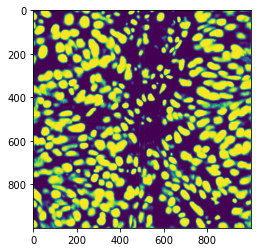

In [110]:
generate_mask(mem_crop, os.path.join(model_path, save_paths[30]))

In [ ]:
generate_mask(mem_crop, os.path.join(model_path, save_paths[49]))